# Diffusivity - Brownian motion from event driven simulation of molecular and granular gases

## Import libraries and dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections
from matplotlib import rc
import os
import sys
sys.path.append("../")

from scipy import stats
from scipy.optimize import curve_fit
from scipy.linalg import norm

from config import results_folder, plots_folder

## Plot details

In [2]:
plt.style.use('bmh')
%matplotlib inline
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 4
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['font.size'] = 12
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14

matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath} \usepackage{bm}"]

## Utility functions

In [3]:
def read_and_return_msd_data(filenames, timestep, t_stop, runs):
    if timestep == 0:
        if t_stop >= 1000:
            times = np.zeros(101)
        else:
            times = np.zeros(51)
    else:
        times = np.arange(0, (int(t_stop/timestep)+1))*timestep
    msd_matrix = np.zeros((runs, len(times)))
    q_speed_matrix = np.zeros((runs, len(times)))
    for i in range(runs):
        filename = filenames.replace('X', str(i))
        msd_data = np.load(file=os.path.join(results_folder, filename))
        msd_matrix[i, :] = msd_data[:, 1]
        q_speed_matrix[i, :] = msd_data[:, 2]
        if timestep == 0:
            times = msd_data[:, 0]
    return times, np.mean(msd_matrix, axis=0), np.std(msd_matrix, axis=0), np.mean(q_speed_matrix, axis=0), np.std(q_speed_matrix, axis=0)

In [4]:
def log_function(t, scaling_factor):
    return np.log(t)*scaling_factor

In [5]:
def slope_function(t, scaling_factor):
    return t*scaling_factor

In [6]:
def a2(d, xi):
    return 16*(1-xi)*(1-2*xi**2)/(9+24*d+8*d*xi-41*xi+30*xi**2*(1-xi))

def tau_analytical(T0, xi, N, r, m=1):
    # Num and exp result China + Brilliantov and Poshel with a2=0
    n = N/1
    eta = n*4*np.pi*r**3/3
    g = (2-eta)/(2*(1-eta)**3)
    #a = a2(3, xi)
    a = 0
    #print(a)
    return (np.sqrt(T0/m)*(1-xi**2)/6*4*np.sqrt(np.pi)*g*(2*r)**2*n*(1+3*a/16))**(-1)

def D0(T0, xi, N, r, m):
    n = N/1
    eta = n*4*np.pi*r**3/3
    g = (2-eta)/(2*(1-eta)**3)
    #a = a2(3, xi)
    a = 0
    return 3*np.sqrt(T0)/((1+xi)**2*np.sqrt(m*np.pi)*n*g*(2*r)**2*2*(1+3*a/16)**2)

def gamma_1(T0, d0, m):
    return T0/(d0*m)

def msd(t, d0, gamma0, tau):
    msd_1d = 2*d0*tau*(np.log(1+t/tau)+(1/(tau*gamma0))*((1+t/tau)**(-tau*gamma0)-1))
    return 3*msd_1d

def msd_udsbm(t, d0, gamma0, tau):
    msd_1d = 2*d0*tau**2*gamma0**2*(tau*np.log(1+t/tau)+(tau/(tau*gamma0-1))*((1+t/tau)**(-tau*gamma0+1)-1))/((tau*gamma0-1)**2)
    return 3*msd_1d

def msd_elasticparticles(t, d0, gamma0):
    msd_1d = 2*d0*t+2*d0*(np.exp(-gamma0*t)-1)/gamma0
    return 3*msd_1d

In [7]:
def check_convergence(times, msd_avg, msd_std, runs):
    # Error is given by Central limit theorem
    plt.figure()
    plt.loglog(times, msd_std/np.sqrt(runs))
    plt.title('Standard deviation computed from clt')
    plt.show()

## Diffusivity

In [8]:
def compute_diffusivity(N, xi, rad, tstop, timestep, runs, save_plot=False):
    filenames = f"msd_pbc_eq_start_N_{N}_r_{rad}_xi_{xi}_tstop_{tstop}_dt_{timestep}_X.npy"
    print(filenames)
    print(f'---------- xi: {xi} ------------')
    times, msd_avg, msd_std, q_speed_avg, q_speed_std = read_and_return_msd_data(filenames, timestep, tstop, runs)
    
    T0 = q_speed_avg[0]/3
    
    # extract interesting data
    times = times[1:]
    msd_avg = msd_avg[1:]
    msd_std = msd_std[1:]
    q_speed_avg = q_speed_avg[1:]
    q_speed_std = q_speed_std[1:]
    # compute std from clt
    std_clt = msd_std/np.sqrt(runs)
    print(f'max std_clt : {max(std_clt)}')
    print('first time value', times[0], 'last time value', times[-1])
    
    d_msd = np.gradient(msd_avg, times)
    d0 = D0(T0, xi, N, rad, m=1)
    plt.figure()
    plt.loglog(times, d_msd/(6*d0), label='Numerical values')
    if xi == 1:
        plt.plot([times[0], times[-1]], [1, 1], 'k--', label='Unity reference')
    else:
        tau = tau_analytical(T0, xi, N, rad, m=1)
        plt.plot(times, 1/(1+times/tau), 'k--', label=r'$\frac{1}{1+t/\tau_0}$')
    plt.ylabel(r'$\frac{D(t)}{D_0}$')
    plt.xlabel(r'$t$')
    plt.legend()
    if save_plot:
        print('Remember to change to save later')
        #plt.savefig(os.path.join(plots_folder, f'diffusivity_N_{N}_xi_{xi}_rad_{rad}_tstop_{tstop}.pdf'))
    plt.show()

In [9]:
def forward_difference(msd, times):
    fd = np.zeros_like(msd)
    fd[:-1] = (msd[1:]-msd[:-1])/(times[1:]-times[:-1])
    fd[-1] = (msd[-1]-msd[-2])/(times[-1]-times[-2])
    return fd

def backward_difference(msd, times):
    bd = np.zeros_like(msd)
    bd[1:] = (msd[1:]-msd[:-1])/(times[1:]-times[:-1])
    bd[0] = (msd[1]-msd[0])/(times[1]-times[0])
    return bd

def mean_fb_difference(msd, times):
    fd = forward_difference(msd, times)
    bd = backward_difference(msd, times)
    return (fd+bd)/2

In [10]:
def compare_alternatives_diffusivity(N, xi, rad, tstop, timestep, runs):
    filenames = f"msd_pbc_eq_start_N_{N}_r_{rad}_xi_{xi}_tstop_{tstop}_dt_{timestep}_X.npy"
    print(filenames)
    print(f'---------- xi: {xi} ------------')
    times, msd_avg, msd_std, q_speed_avg, q_speed_std = read_and_return_msd_data(filenames, timestep, tstop, runs)
    
    T0 = q_speed_avg[0]/3
    
    # extract interesting data
    times = times[1:]
    msd_avg = msd_avg[1:]
    msd_std = msd_std[1:]
    q_speed_avg = q_speed_avg[1:]
    q_speed_std = q_speed_std[1:]
    # compute std from clt
    std_clt = msd_std/np.sqrt(runs)
    print(f'max std_clt : {max(std_clt)}')
    print('first time value', times[0], 'last time value', times[-1])
    
    d_msd = np.gradient(msd_avg, times)
    d0 = D0(T0, xi, N, rad, m=1)
    plt.figure()
    plt.loglog(times, d_msd/(6*d0), label='NumPy')
    fd = forward_difference(msd_avg, times)
    bd = backward_difference(msd_avg, times)
    mean_fb_diff = (fd+bd)/2
    plt.loglog(times, fd/(6*d0), label='FD')
    plt.loglog(times, bd/(6*d0), label='BD')
    plt.loglog(times, mean_fb_diff/(6*d0), label='Mean FD and BD')
    #plt.loglog(times, np.abs(mean_fb_diff-d_msd)/(6*d0), label="Diff Numpy and mean")
    if xi == 1:
        plt.plot([times[0], times[-1]], [1, 1], 'k--', label='Unity reference')
    else:
        tau = tau_analytical(T0, xi, N, rad, m=1)
        plt.plot(times, 1/(1+times/tau), 'k--', label=r'$\frac{1}{1+t/\tau_0}$')
    plt.ylabel(r'$\frac{D(t)}{D_0}$')
    plt.xlabel(r'$t$')
    plt.legend()
    plt.show()

msd_pbc_eq_start_N_1000_r_0.025_xi_1.0_tstop_100_dt_0.0_X.npy
---------- xi: 1.0 ------------
max std_clt : 0.40828930822774306
first time value 0.01 last time value 100.0
Remember to change to save later


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


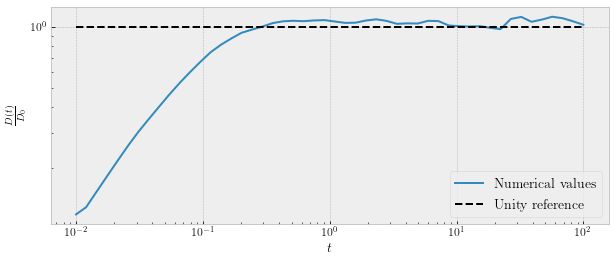

msd_pbc_eq_start_N_1000_r_0.025_xi_1.0_tstop_100_dt_0.0_X.npy
---------- xi: 1.0 ------------
max std_clt : 0.40828930822774306
first time value 0.01 last time value 100.0


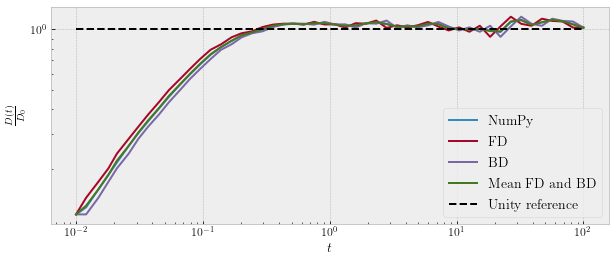

msd_pbc_eq_start_N_1000_r_0.025_xi_0.8_tstop_1000_dt_0.0_X.npy
---------- xi: 0.8 ------------
max std_clt : 0.045885272509033
first time value 0.01 last time value 1000.0
Remember to change to save later


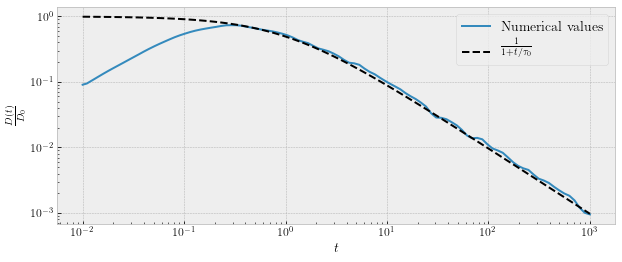

msd_pbc_eq_start_N_1000_r_0.025_xi_0.8_tstop_1000_dt_0.0_X.npy
---------- xi: 0.8 ------------
max std_clt : 0.045885272509033
first time value 0.01 last time value 1000.0


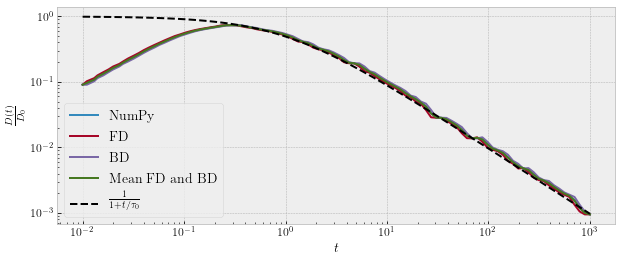

msd_pbc_eq_start_N_1000_r_0.025_xi_0.3_tstop_1000_dt_0.0_X.npy
---------- xi: 0.3 ------------
max std_clt : 0.0343641499857861
first time value 0.01 last time value 1000.0
Remember to change to save later


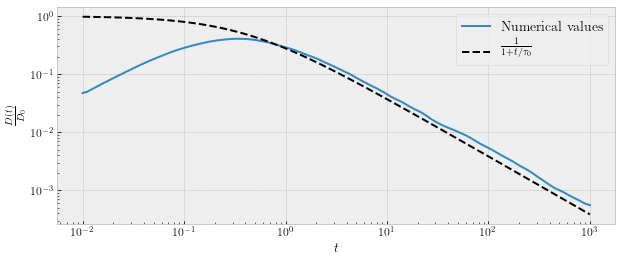

msd_pbc_eq_start_N_1000_r_0.025_xi_0.3_tstop_1000_dt_0.0_X.npy
---------- xi: 0.3 ------------
max std_clt : 0.0343641499857861
first time value 0.01 last time value 1000.0


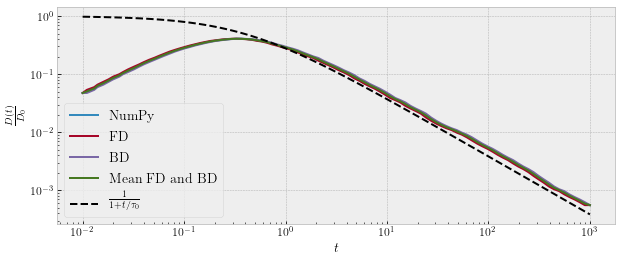

In [11]:
N = 1000
xi_values = [1.0, 0.8, 0.3]
rad = 1/40
tstop_values = [100, 1000, 1000]
save_file_values = [True, True, True]
timestep = 0.0
number_of_runs = 4

for i in range(len(xi_values)):
    xi = xi_values[i]
    tstop = tstop_values[i]
    save_file = save_file_values[i]
    compute_diffusivity(N, xi, rad, tstop, timestep, number_of_runs, save_file)
    compare_alternatives_diffusivity(N, xi, rad, tstop, timestep, number_of_runs)

msd_pbc_eq_start_N_1000_r_0.025_xi_1.0_tstop_10_dt_0.1_X.npy
---------- xi: 1.0 ------------
max std_clt : 0.047744633611208086
first time value 0.1 last time value 10.0


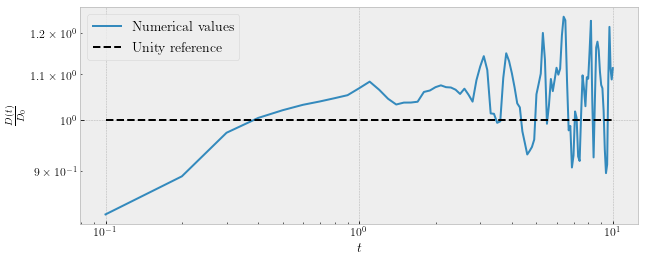

msd_pbc_eq_start_N_1000_r_0.025_xi_1.0_tstop_10_dt_0.1_X.npy
---------- xi: 1.0 ------------
max std_clt : 0.047744633611208086
first time value 0.1 last time value 10.0


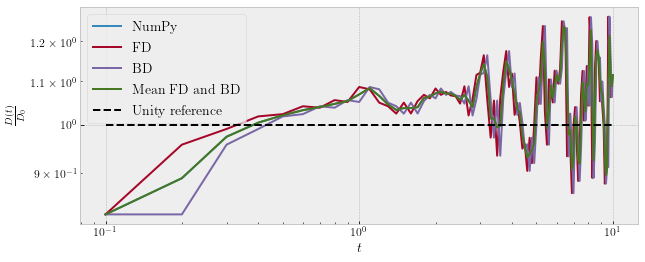

msd_pbc_eq_start_N_1000_r_0.025_xi_0.99_tstop_1000_dt_0.1_X.npy
---------- xi: 0.99 ------------
max std_clt : 0.6005527998230228
first time value 0.1 last time value 1000.0


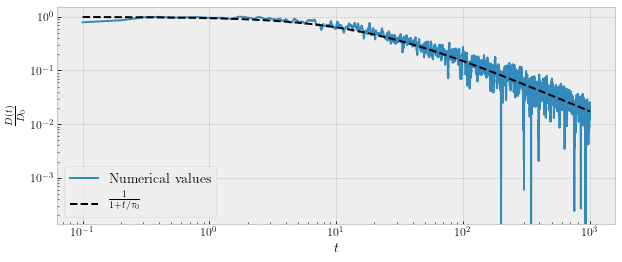

msd_pbc_eq_start_N_1000_r_0.025_xi_0.99_tstop_1000_dt_0.1_X.npy
---------- xi: 0.99 ------------
max std_clt : 0.6005527998230228
first time value 0.1 last time value 1000.0


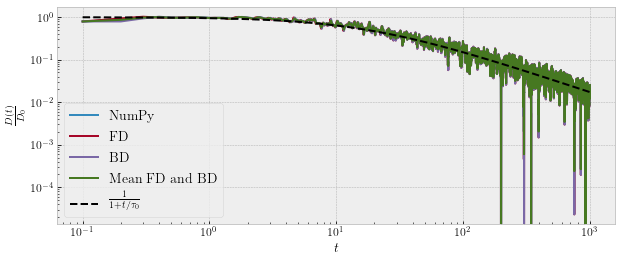

msd_pbc_eq_start_N_1000_r_0.025_xi_0.8_tstop_1000_dt_0.1_X.npy
---------- xi: 0.8 ------------
max std_clt : 0.021182167238502508
first time value 0.1 last time value 1000.0


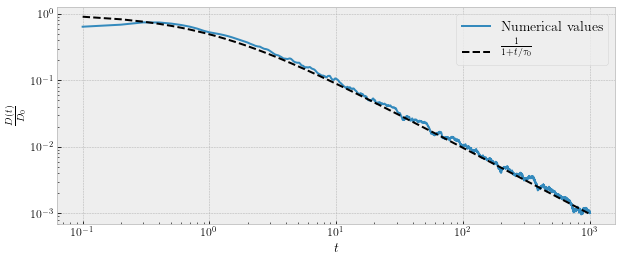

msd_pbc_eq_start_N_1000_r_0.025_xi_0.8_tstop_1000_dt_0.1_X.npy
---------- xi: 0.8 ------------
max std_clt : 0.021182167238502508
first time value 0.1 last time value 1000.0


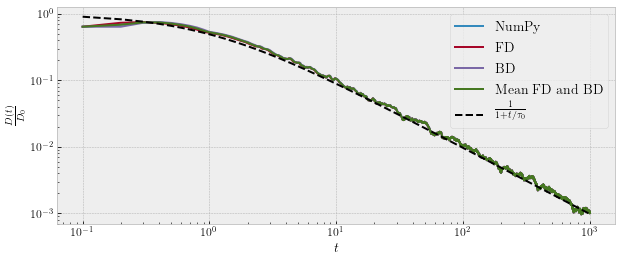

msd_pbc_eq_start_N_1000_r_0.025_xi_0.3_tstop_1000_dt_0.1_X.npy
---------- xi: 0.3 ------------
max std_clt : 0.037412009819097015
first time value 0.1 last time value 1000.0


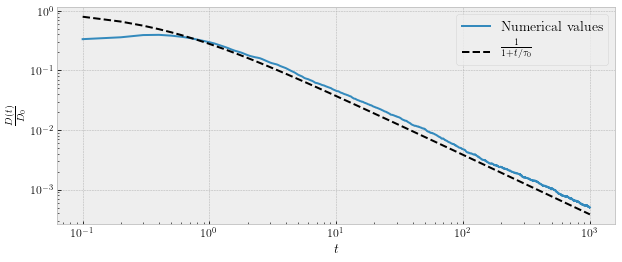

msd_pbc_eq_start_N_1000_r_0.025_xi_0.3_tstop_1000_dt_0.1_X.npy
---------- xi: 0.3 ------------
max std_clt : 0.037412009819097015
first time value 0.1 last time value 1000.0


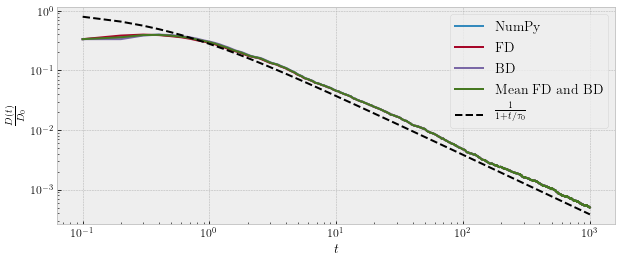

msd_pbc_eq_start_N_1000_r_0.025_xi_0.1_tstop_1000_dt_0.1_X.npy
---------- xi: 0.1 ------------
max std_clt : 0.05855706907457283
first time value 0.1 last time value 1000.0


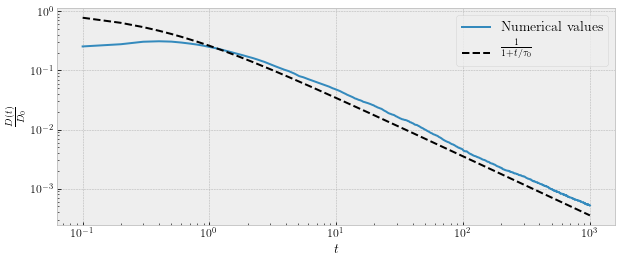

msd_pbc_eq_start_N_1000_r_0.025_xi_0.1_tstop_1000_dt_0.1_X.npy
---------- xi: 0.1 ------------
max std_clt : 0.05855706907457283
first time value 0.1 last time value 1000.0


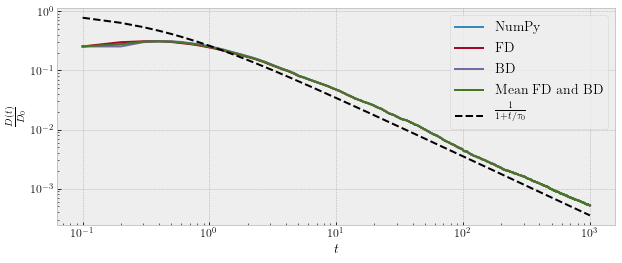

In [12]:
N = 1000
xi_values = [1.0, 0.99, 0.8, 0.3, 0.1]
rad = 1/40
tstop_values = [10, 1000, 1000, 1000, 1000]
timestep = 0.1
number_of_runs = 4

for i in range(len(xi_values)):
    xi = xi_values[i]
    tstop = tstop_values[i]
    compute_diffusivity(N, xi, rad, tstop, timestep, number_of_runs)
    compare_alternatives_diffusivity(N, xi, rad, tstop, timestep, number_of_runs)